In [108]:
#%pip install numpy
#%pip install pandas
#%pip install pickle
#%pip install ipywidgets
#%pip install matplotlib
import numpy as np
import pandas as pd
import pickle
import copy
from ipywidgets import interact
import matplotlib.pyplot as plt
#%pip install pyarrow
##%pip install fastparquet

### J'ai des pb avec lire les pickles sur mon google drive donc je laisse de téco pr l'instant


In [2]:
df0 = pd.read_parquet('pass0.parquet')
df1 = pd.read_parquet('pass1.parquet')

In [42]:
print(list(df0))
df0.head()
df0.info()

['IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'GM.T', 'GM.lat_int', 'GM.lon_int', 'GM.acc.xyz.z', 'GM.acc.xyz.y', 'GM.acc.xyz.x', 'GM.obd.spd_veh.value']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IRI_mean              2274 non-null   float64
 1   IRI_sequence          2274 non-null   object 
 2   GM.TS_or_Distance     2274 non-null   object 
 3   GM.T                  2274 non-null   object 
 4   GM.lat_int            2274 non-null   object 
 5   GM.lon_int            2274 non-null   object 
 6   GM.acc.xyz.z          2274 non-null   object 
 7   GM.acc.xyz.y          2274 non-null   object 
 8   GM.acc.xyz.x          2274 non-null   object 
 9   GM.obd.spd_veh.value  2274 non-null   object 
dtypes: float64(1), object(9)
memory usage: 177.8+ KB


In [4]:
def show(col):
    try:
        plt.hist(df0[col].map(len), bins=20)
        plt.show()
        plt.plot(df0.loc[0,col])
    except:
        ...#reeee
    
interact(show, col=list(df0));

interactive(children=(Dropdown(description='col', options=('IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'G…

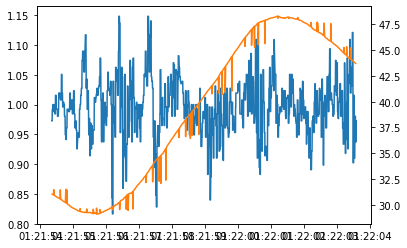

In [5]:
s0 = df0.loc[0]
mask = s0['GM.T'] == 'acc.xyz'
accT = s0['GM.TS_or_Distance'][mask]
accZ = s0['GM.acc.xyz.z']
obdT = s0['GM.TS_or_Distance'][~mask]
obd = s0['GM.obd.spd_veh.value']

# plt.plot(accZ)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(accT, accZ, color='#1f77b4')
ax2.plot(obdT, obd, color='#ff7f0e');

# weird stuff on the orange curve (?)

In [138]:
df_0_train = df0[:170]
df_0_val = df0[2000:]
df_0_test = df0[1500:1503]

In [139]:
from torch.utils.data import Dataset

class MyDS(Dataset):
    def __init__(self, fname, size=None):
        df = fname
        zacc = df['GM.acc.xyz.z'] # Series[arr[:]float]
        
        if not size:
            size = zacc.map(len).quantile(.1)
            size = (int(size) // 32) * 32
        self.sz = size
        zacc = zacc[zacc.map(len) >= size]
        
        def truncate(arr):
            return arr[:size]
        zacc = np.stack(zacc.map(truncate)).astype('float32')
        print(zacc.shape, size)
        self.zacc = zacc
        
    
    def __getitem__(self, idx):
        return self.zacc[idx][None,:]
    
    def __len__(self):
        return len(self.zacc)

L = 1048
train_data = MyDS(df_0_train, L) #size = N
val_data = MyDS(df_0_val, L) #size = N
test_data = MyDS(df_0_test, L) #size = N

dataloader_train = DataLoader(train_data, shuffle=True)
dataloader_val = DataLoader(val_data, shuffle=True)
dataloader_test = DataLoader(test_data, shuffle=True)


(168, 1048) 1048
(269, 1048) 1048
(3, 1048) 1048


In [99]:
import torch
import torch.nn as nn 

class AE(nn.Module):
    def __init__(self, hidden_units, num_features, L,latent_features=3):
        super().__init__()
        
        mid = L // (4*4*4) #latent space dims
        assert L % (4*4*4) == 0
        
        self.encoder = nn.Sequential(
            
            nn.LSTM(input_size =num_features, hidden_size =hidden_units),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.LSTM(input_size =hidden_units, hidden_size =num_features)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded
        
    def get_latent(self,x):
        return self.encoder(x)

In [100]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n#.reshape((self.n_features, self.embedding_dim))

    def get_latent(self,x):
        return self.encoder(x)

In [101]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim, n_features):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        #x = x.repeat(self.seq_len, self.n_features)
        #x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        #x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [102]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def get_latent(self,x):
        return self.encoder(x)

In [11]:
def visualization(x,display = True):
    tsne = TSNE(n_components=2, n_iter=3000, )
    vis = tsne.fit_transform(x)
    if display:
        fig, ax = plt.subplots()
        ax.scatter(*vis.T)
        plt.show()
    else:
        return vis

In [220]:
hidden_units = 16
num_features = 1
seq_len = L
model = RecurrentAutoencoder(seq_len, num_features,hidden_units)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1048, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 16, batch_first=True)
    (rnn2): LSTM(16, 32, batch_first=True)
    (output_layer): Linear(in_features=32, out_features=1048, bias=True)
  )
)

In [221]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss() # L1 reduction='sum'
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for seq_true in train_dataset:
            print(seq_true)
            optimizer.zero_grad()
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true[0])

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_pred = model(seq_true[0])

                loss = criterion(seq_pred, seq_true[0])
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [222]:
model, history = train_model(
  model, 
  dataloader_train, 
  dataloader_val, 
  n_epochs=2
)

tensor([[[1.0078, 1.0078, 1.0352,  ..., 0.9844, 0.9844, 0.9844]]])
tensor([[[0.9688, 0.9688, 0.9688,  ..., 1.0078, 1.0078, 0.9961]]])
tensor([[[0.9531, 0.9531, 0.9531,  ..., 1.0391, 0.9570, 0.9570]]])
tensor([[[0.9805, 1.0156, 1.0156,  ..., 0.9805, 0.9805, 1.0078]]])
tensor([[[1.0039, 1.0039, 1.0039,  ..., 0.9844, 0.9844, 0.9844]]])
tensor([[[1.0078, 1.0078, 0.9844,  ..., 0.9844, 0.9844, 0.9844]]])
tensor([[[1.1367, 1.1367, 1.0469,  ..., 0.8672, 0.8672, 0.9570]]])
tensor([[[0.9883, 0.9883, 0.9883,  ..., 1.0156, 1.0391, 1.0391]]])
tensor([[[0.9375, 0.9844, 0.9844,  ..., 1.0430, 1.0430, 1.0430]]])
tensor([[[0.9727, 0.9688, 0.9688,  ..., 0.9766, 0.9766, 0.9883]]])
tensor([[[0.9648, 0.9648, 0.9609,  ..., 1.0078, 1.0078, 1.0078]]])
tensor([[[0.9883, 0.9883, 0.9688,  ..., 0.9805, 0.9805, 0.9805]]])
tensor([[[1.0586, 0.8945, 0.8945,  ..., 0.9414, 0.9414, 0.9414]]])
tensor([[[1.0273, 1.0273, 0.9766,  ..., 0.9883, 0.9883, 0.9727]]])
tensor([[[1.0156, 1.0156, 1.0156,  ..., 1.0000, 1.0000, 1.0000

C:\tools\miniconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 1048])) that is different to the input size (torch.Size([1, 1, 1048])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0078, 0.9727, 0.9727]]])
tensor([[[0.9805, 0.9805, 0.9805,  ..., 1.0000, 1.0000, 1.0000]]])
tensor([[[1.0195, 1.0195, 1.0234,  ..., 1.0000, 1.0000, 1.0000]]])
tensor([[[0.9766, 0.9805, 0.9805,  ..., 1.0000, 1.0000, 1.0000]]])
tensor([[[0.9766, 1.0508, 1.0508,  ..., 0.9648, 0.9648, 0.9648]]])
tensor([[[1.0391, 1.0391, 0.9805,  ..., 1.0430, 1.0430, 1.0430]]])
tensor([[[1.0039, 1.0039, 1.0039,  ..., 0.9375, 0.9375, 0.9375]]])
tensor([[[0.9766, 0.9727, 0.9727,  ..., 1.0234, 1.0234, 1.0039]]])
tensor([[[1.0078, 1.0078, 0.9727,  ..., 1.0078, 1.0078, 0.9844]]])
tensor([[[1.0391, 1.0391, 1.0117,  ..., 1.0117, 0.9805, 0.9805]]])
tensor([[[1.0586, 1.0586, 1.0586,  ..., 0.9727, 0.9727, 0.9727]]])
tensor([[[0.9844, 0.9844, 0.9844,  ..., 0.9805, 0.9805, 0.9805]]])
tensor([[[0.9805, 0.9805, 0.9805,  ..., 1.0078, 1.0078, 1.0156]]])
tensor([[[0.9414, 0.9414, 0.9414,  ..., 1.0352, 1.0352, 1.0352]]])
tensor([[[1.0156, 1.0156, 1.0156,  ..., 1.0039, 1.0039, 1.0039

tensor([[[1.0508, 1.0586, 1.0586,  ..., 1.0547, 1.0547, 1.0547]]])
tensor([[[1.0039, 1.0117, 1.0156,  ..., 0.9922, 0.9922, 0.9922]]])
tensor([[[1.0000, 1.0000, 1.0117,  ..., 1.0117, 1.0117, 1.0117]]])
tensor([[[1.0234, 1.0156, 1.0156,  ..., 0.9961, 0.9961, 1.0000]]])
tensor([[[0.9883, 0.9883, 0.9883,  ..., 0.9727, 0.9531, 0.9531]]])
tensor([[[1.0039, 1.0039, 1.0039,  ..., 1.0039, 1.0039, 1.0039]]])
Epoch 1: train loss 0.996504898582186 val loss 0.9964424544550672
tensor([[[1.0508, 1.0586, 1.0586,  ..., 1.0547, 1.0547, 1.0547]]])
tensor([[[0.9883, 0.9883, 0.9883,  ..., 1.0000, 1.0000, 1.0000]]])
tensor([[[1.0078, 1.0078, 1.0078,  ..., 1.0078, 1.0078, 1.0078]]])
tensor([[[0.9727, 0.9063, 0.9063,  ..., 1.0977, 1.0977, 1.0977]]])
tensor([[[0.9844, 0.9844, 0.9844,  ..., 1.0430, 1.0430, 1.0430]]])
tensor([[[0.9727, 0.9688, 0.9688,  ..., 0.9766, 0.9766, 0.9883]]])
tensor([[[1.0195, 1.0195, 1.0234,  ..., 1.0000, 1.0000, 1.0000]]])
tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9063, 0.9063, 0.9063]

tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9688, 0.9688, 0.9688]]])
tensor([[[0.9883, 0.9883, 0.9883,  ..., 1.0352, 1.0352, 1.0391]]])
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0078, 0.9727, 0.9727]]])
tensor([[[0.9453, 0.9453, 0.9453,  ..., 1.0156, 1.0156, 1.0156]]])
tensor([[[1.0234, 1.0234, 1.0234,  ..., 1.0430, 1.0430, 1.0430]]])
tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0117, 1.0117, 1.0117]]])
tensor([[[0.9531, 0.9531, 0.9531,  ..., 0.9570, 0.9609, 0.9609]]])
tensor([[[0.9805, 0.9805, 0.9805,  ..., 1.0000, 1.0000, 1.0000]]])
tensor([[[1.0625, 1.0625, 1.0625,  ..., 1.0586, 1.0586, 1.0586]]])
tensor([[[0.9766, 1.0039, 1.0039,  ..., 1.0078, 1.0078, 1.0078]]])
tensor([[[0.9375, 0.9375, 1.0039,  ..., 1.0391, 1.0391, 1.0469]]])
tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961]]])
tensor([[[0.9688, 0.9688, 0.9688,  ..., 1.0039, 1.0039, 1.0039]]])
tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922]]])
tensor([[[1.0078, 1.0117, 1.0117,  ..., 0.9961, 0.9961, 0.9961

In [167]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 16, batch_first=True)
    (rnn2): LSTM(16, 32, batch_first=True)
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [168]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

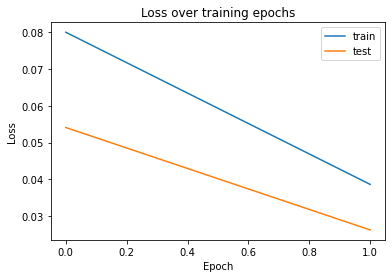

In [121]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [211]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.MSELoss()
    with torch.no_grad():
        model = model.eval()
    for seq_true in dataset:
        print(seq_true)
        seq_pred = model(seq_true)
        print(seq_pred)
        loss = criterion(seq_pred, seq_true)

        predictions.append(seq_pred.detach().numpy().flatten())
        losses.append(loss.item())
    return predictions, losses

In [212]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, data)
    sq_in_data = []
    for x in dataloader:
        sq_in_data.append(x[0][0])
    ax.plot(sq_in_data[0], label='true')
    ax.plot(predictions, label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

In [213]:
for i,item in enumerate([dataloader_test,dataloader_test,dataloader_test]):
    print(i, "and" , item)


0 and <torch.utils.data.dataloader.DataLoader object at 0x0000023AAE9BA3D0>
1 and <torch.utils.data.dataloader.DataLoader object at 0x0000023AAE9BA3D0>
2 and <torch.utils.data.dataloader.DataLoader object at 0x0000023AAE9BA3D0>


tensor([[[1.0117, 1.0117, 1.0117,  ..., 0.9922, 0.9922, 0.9766]]])
tensor([[[0.8537]]], grad_fn=<AddBackward0>)
tensor([[[0.9453, 0.9453, 0.9453,  ..., 1.0234, 1.0234, 1.0234]]])


C:\tools\miniconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 1, 1048])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[[0.8537]]], grad_fn=<AddBackward0>)
tensor([[[1.0234, 1.0234, 0.9688,  ..., 1.0156, 1.0469, 1.0469]]])
tensor([[[0.8537]]], grad_fn=<AddBackward0>)


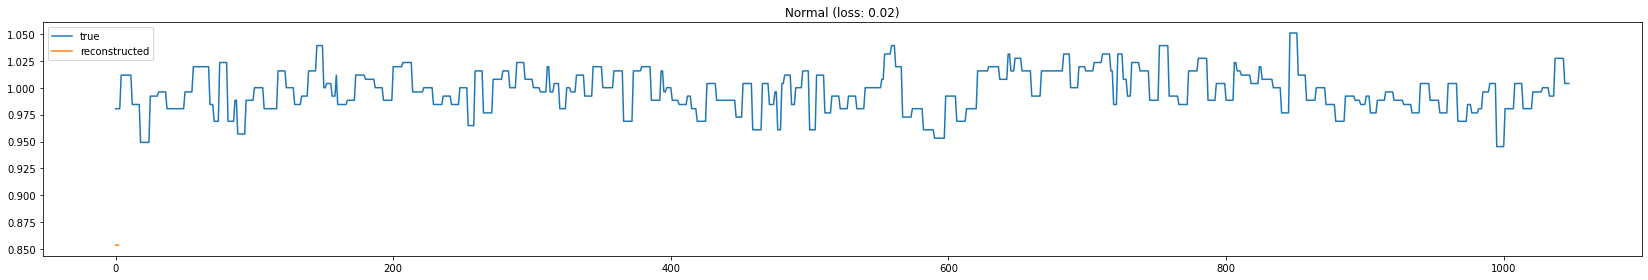

In [216]:
fig, axs = plt.subplots(
  nrows=1,
  ncols=1,
  sharey=True,
  sharex=True,
  figsize=(23, 4)
)
plot_prediction(dataloader_test, model, title='Normal', ax=axs)

fig.tight_layout();

In [15]:
from torch.utils.data import DataLoader
#in_channels = 
#out_channels = 
#kernel_size= 
seq_len = L
hidden_units = 16
num_features = 1
dataloader = DataLoader(my_data, shuffle=True)
do_run = False
do_run = True

if (do_run):
    #model = AE(hidden_units,num_features,L)

    model = RecurrentAutoencoder(seq_len, num_features, hidden_units)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

    loss_array = []
    pred_array = []
    real = []
    for x in dataloader:
        real.append(x)
        pred = model(x)
        loss = loss_fn(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_array.append(float(loss))
        pred_array.append(pred)        
        print(float(loss))

1.1623467206954956
1.1223927736282349
1.1269527673721313
1.1217386722564697
1.103352665901184
1.12309730052948
1.1037455797195435
1.08735990524292
1.0952284336090088
1.092734932899475
1.0608023405075073
1.0857250690460205
1.0796290636062622
1.08242666721344
1.0790812969207764
1.0755822658538818
1.058769941329956
1.040618658065796
1.0783686637878418
1.034674048423767
1.0373272895812988
1.035539150238037
1.0284377336502075
1.0275139808654785
1.0263947248458862
1.011577844619751
1.01453697681427
0.9431893229484558
1.005706787109375
0.9891200065612793
0.9835110902786255
0.9858372807502747
0.9726735949516296
0.9815409183502197
0.9838750958442688
0.9692811369895935
0.963548481464386
0.9838230013847351
0.9479990601539612
0.977009117603302
0.9620662331581116
0.9524503946304321
0.9441720843315125
0.9474943280220032
0.930755615234375
0.9307299852371216
0.9369900822639465
0.9231681227684021
0.9284842610359192
0.939072847366333
0.9331989288330078
0.9274178743362427
0.9102978110313416
0.91828256845

0.1790711134672165
0.16523027420043945
0.18111629784107208
0.18359550833702087
0.1770261526107788
0.17309848964214325
0.17622874677181244
0.17541565001010895
0.16792364418506622
0.17433933913707733
0.18638645112514496
0.172403946518898
0.17351138591766357
0.166302889585495
0.16249652206897736
0.1610690802335739
0.15692825615406036
0.16961370408535004
0.16302485764026642
0.17362570762634277
0.16523683071136475
0.15337146818637848
0.17157891392707825
0.16982559859752655
0.16524535417556763
0.16522474586963654
0.16152144968509674
0.1592818796634674
0.15843260288238525
0.16498886048793793
0.14663584530353546
0.1507595330476761
0.16173452138900757
0.15806728601455688
0.15377938747406006
0.15702813863754272
0.14577248692512512
0.15310269594192505
0.15701572597026825
0.1409355103969574
0.15449075400829315
0.1478305608034134
0.15076784789562225
0.14910012483596802
0.15226103365421295
0.14007742702960968
0.1461460292339325
0.14649872481822968
0.15105880796909332
0.14645028114318848
0.1450772136

0.03407057747244835
0.034348014742136
0.03189987689256668
0.02869625762104988
0.030063698068261147
0.03059053048491478
0.04014910012483597
0.03181060776114464
0.03431044891476631
0.030809441581368446
0.031145263463258743
0.031043441966176033
0.029969917610287666
0.02882702648639679
0.03116522543132305
0.027418596670031548
0.036711685359478
0.029090121388435364
0.024595187976956367
0.029919015243649483
0.03629768267273903
0.029248017817735672
0.02612760104238987
0.02610481157898903
0.028655823320150375
0.025706667453050613
0.024921439588069916
0.026620395481586456
0.027396105229854584
0.03007466159760952
0.0284626092761755
0.02799059823155403
0.029006987810134888
0.02756965532898903
0.029470881447196007
0.02735239267349243
0.03164277225732803
0.024983104318380356
0.024935780093073845
0.02851153537631035
0.024077588692307472
0.024231068789958954
0.022047745063900948
0.028567863628268242
0.025053979828953743
0.02598881907761097
0.026075877249240875
0.02496396377682686
0.02958989329636097


0.010760487988591194
0.005858583375811577
0.0071022906340658665
0.012279326096177101
0.0044485521502792835
0.007012197747826576
0.0067190732806921005
0.006549868267029524
0.004680858924984932
0.007182636763900518
0.005338162649422884
0.0030495142564177513
0.006660819984972477
0.009480826556682587
0.007735131308436394
0.00694365706294775
0.007900797761976719
0.003390279598534107
0.006344845052808523
0.005327504128217697
0.005328725092113018
0.0058157779276371
0.006364152766764164
0.008032020181417465
0.004685964901000261
0.00383733375929296
0.0055925571359694
0.008970077149569988
0.008529849350452423
0.007863825187087059
0.007732250262051821
0.004210474900901318
0.0036951296497136354
0.005729584489017725
0.007620344404131174
0.00580265186727047
0.0038360320031642914
0.005516103934496641
0.005905444733798504
0.00482788123190403
0.008498557843267918
0.007874678820371628
0.004365747794508934
0.004897198639810085
0.005320718511939049
0.005963931791484356
0.00404168339446187
0.00528599787503

0.0024831939954310656
0.0029016914777457714
0.003445941023528576
0.0020993275102227926
0.003977026790380478
0.0009291763999499381
0.0008870463352650404
0.0010027015814557672
0.0015399835538119078
0.002321807434782386
0.0017121272394433618
0.0082825543358922
0.0035488412249833345
0.002077849581837654
0.0017014419427141547
0.001270787208341062
0.0096487021073699
0.001762224710546434
0.0013842403423041105
0.0023351642303168774
0.0020955130457878113
0.0016114999307319522
0.003706797957420349
0.002346625318750739
0.0009895130060613155
0.001564281526952982
0.0022741039283573627
0.0051656910218298435
0.005321269854903221
0.0017888436559587717
0.0012193836737424135
0.0016560351941734552
0.0018490004586055875
0.0011922151315957308
0.005186846479773521
0.001740708714351058
0.0018454937962815166
0.0016147511778399348
0.001079810899682343
0.0041665248572826385
0.0025937531609088182
0.000898010388482362
0.0025964973028749228
0.006879076361656189
0.003598792478442192
0.0009213020093739033
0.00125890

0.0010499123018234968
0.003701058216392994
0.0006722677499055862
0.0005917910020798445
0.000314232223900035
0.0005047537852078676
0.0010293226223438978
0.0014538733521476388
0.0009481143206357956
0.0001696366525720805
0.0008447555010206997
0.00142560841049999
0.0004083746753167361
0.0010765878250822425
0.0008041705586947501
0.0009191444260068238
0.0001992255129152909
0.0003502326726447791
0.0006257957429625094
0.0009088744991458952
0.0021931191440671682
0.0012485429178923368
0.005351315252482891
0.0010892724385485053
0.0033327890560030937
0.0001242934522451833
0.002024290384724736
0.001001711469143629
0.00030320079531520605
0.003951789811253548
0.0019786725752055645
0.0007096627959981561
0.003790315706282854
0.0009873004164546728
0.003092030296102166
0.0009089009836316109
0.0033836590591818094
0.0015082266181707382
0.0016367726493626833
0.00432707229629159
0.0016431905096396804
0.0013255716767162085
0.00011783784430008382
0.0010361913591623306
0.0037004470359534025
0.000800646317657083

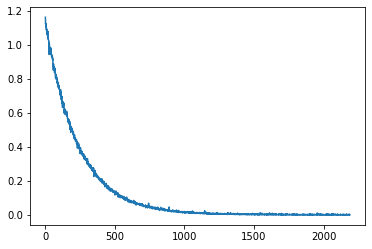

In [16]:
if (do_run):
    steps_plot = np.arange(0,len(loss_array),1)

    plt.plot(steps_plot,loss_array)
    plt.show()

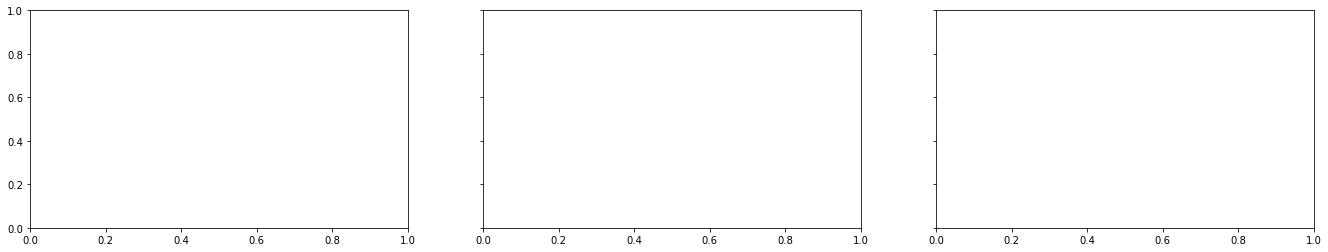

In [39]:
fig, ax = plt.subplots(
  nrows=1,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(23, 4)
)


In [40]:
print(real[-1].detach().numpy()[0][0])
print(pred_array[-1].detach().numpy()[0][0])
print("Loss  array size ", len(loss_array))
print("pred  array size ", len(pred_array))
print("real  array size ", len(real))

[0.9805 0.9805 0.9805 ... 0.9961 0.9961 0.9961]
[0.98598945]
Loss  array size  2190
pred  array size  2190
real  array size  2190


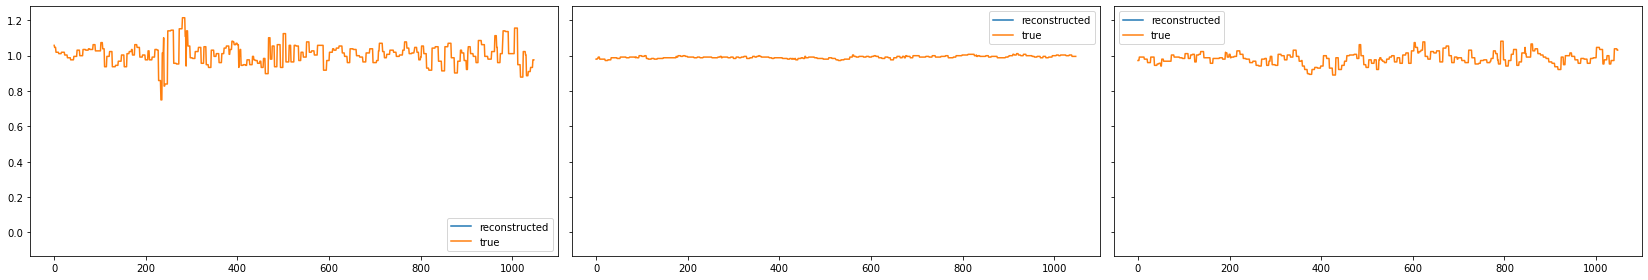

In [41]:
for i in range(3):
    ax[i].plot(pred_array[-i].detach().numpy()[0][0], label='reconstructed')
    ax[i].plot(real[-i].detach().numpy()[0][0], label='true')
    #ax[i].set_title('plot (loss: {np.around(pred_losses[0], 2)})')
    ax[i].legend()
fig.tight_layout()
fig